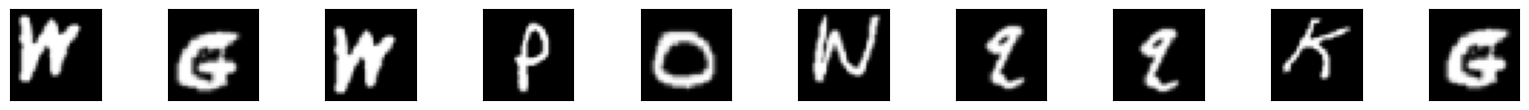

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaded_images = utils.load_images_from_zip()
emnist_data, emnist_labels = utils.load_true_emnist()

emnist_data = emnist_data.astype(np.float32)

utils.plot_images(loaded_images[:10])

In [16]:
loaded_images.shape

(131057, 32, 32)

In [17]:
emnist_data.shape

(112799, 28, 28)

## 1. Resize EMNIST to 32 by 32

In [18]:
import cv2

In [19]:
emnist_data_resized = np.array([cv2.resize(img, (32, 32), interpolation=cv2.INTER_LINEAR) for img in emnist_data])

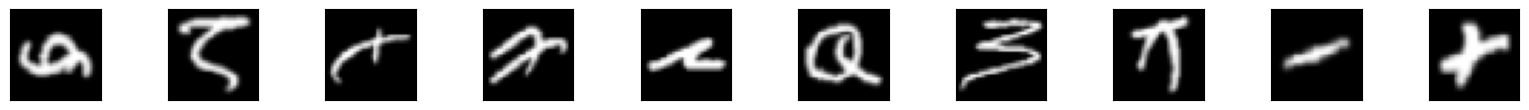

In [20]:
# Let us have a look at the resized images
utils.plot_images(emnist_data_resized[:10])

Doesn't seem like we lost too much granularity (considering the images weren't pretty to begin with, no judgment).

## 2. Train VAE on EMNIST

VAE architecture from [here](https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb)

In [21]:
# Import VAE architecture and utils
from vae import VAE, loss_function, train, test

In [22]:
class EMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [23]:
# Load EMNIST into data loaders for pytorch
transform = transforms.Compose([
    transforms.ToTensor(),
])

#### Train-Test split

In [24]:
emnist_data_train, emnist_data_test, emnist_labels_train, emnist_labels_test = train_test_split(emnist_data_resized, emnist_labels, test_size=0.2, random_state=42)

In [25]:
batch_size = 100

emnist_train = EMNISTDataset(data=emnist_data_train, labels=emnist_labels_train, transform=transform)
emnist_train_loader = DataLoader(dataset=emnist_train, batch_size=batch_size, shuffle=True)

emnist_test = EMNISTDataset(data=emnist_data_test, labels=emnist_labels_test, transform=transform)
emnist_test_loader = DataLoader(dataset=emnist_test, batch_size=batch_size, shuffle=True)

#### VAE loading and init

In [26]:
# Build model
vae = VAE(x_dim=1024, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [27]:
optimizer = optim.Adam(vae.parameters())

In [28]:
for epoch in range(1, 51):
    train(vae, optimizer, emnist_train_loader, epoch)
    test(vae, emnist_test_loader)

Train Epoch: 1 [0/90239 (0%)]	Loss: 710.825312
Train Epoch: 1 [10000/90239 (11%)]	Loss: 335.888984
Train Epoch: 1 [20000/90239 (22%)]	Loss: 332.104688
Train Epoch: 1 [30000/90239 (33%)]	Loss: 330.947344
Train Epoch: 1 [40000/90239 (44%)]	Loss: 315.826445
Train Epoch: 1 [50000/90239 (55%)]	Loss: 310.338594
Train Epoch: 1 [60000/90239 (66%)]	Loss: 312.856094
Train Epoch: 1 [70000/90239 (78%)]	Loss: 312.187930
Train Epoch: 1 [80000/90239 (89%)]	Loss: 316.118555
Train Epoch: 1 [90000/90239 (100%)]	Loss: 309.377031
====> Epoch: 1 Average loss: 323.4549
====> Test set loss: 309.2252
Train Epoch: 2 [0/90239 (0%)]	Loss: 312.955859
Train Epoch: 2 [10000/90239 (11%)]	Loss: 318.409746
Train Epoch: 2 [20000/90239 (22%)]	Loss: 298.046699
Train Epoch: 2 [30000/90239 (33%)]	Loss: 306.943145
Train Epoch: 2 [40000/90239 (44%)]	Loss: 314.996367
Train Epoch: 2 [50000/90239 (55%)]	Loss: 313.099219
Train Epoch: 2 [60000/90239 (66%)]	Loss: 300.671230
Train Epoch: 2 [70000/90239 (78%)]	Loss: 298.651719
Train

In [29]:
from torchvision.utils import save_image

In [32]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    
    save_image(sample.view(64, 1, 32, 32), './samples/sample_' + '.png')